In [1]:
# import and look at pictures
# read and show inline a picture

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
import statistics

%matplotlib inline

In [2]:
# Get all the training images, which are in another main folder
# Combine the training images into two main sets: one for non-vehicles and the other for vehicles
# Here we deal with the non-vehicle set
nv_img_set1 = glob.glob('../Vehicles_Sets/non_vehicles/Extras/*.png')
nv_img_set2 = glob.glob('../Vehicles_Sets/non_vehicles/GTI/*.png')

nv_img_set = []
nv_img_set.extend(nv_img_set1)
nv_img_set.extend(nv_img_set2)

print('# of images in non-vehicle training set is: ({} + {}) = {}'.format(len(nv_img_set1), len(nv_img_set2), len(nv_img_set)))
print(nv_img_set[0])

# of images in non-vehicle training set is: (5068 + 3900) = 8968
../Vehicles_Sets/non_vehicles/Extras/extra1.png


In [3]:
# Get all the training images, which are in another main folder
# Combine the training images into two main sets: one for non-vehicles and the other for vehicles
# Here we deal with the vehicle set
v_img_set1 = glob.glob('../Vehicles_Sets/vehicles/GTI_Far/*.png')
v_img_set2 = glob.glob('../Vehicles_Sets/vehicles/GTI_Left/*.png')
v_img_set3 = glob.glob('../Vehicles_Sets/vehicles/GTI_MiddleClose/*.png')
v_img_set4 = glob.glob('../Vehicles_Sets/vehicles/GTI_Right/*.png')
v_img_set5 = glob.glob('../Vehicles_Sets/vehicles/KITTI_extracted/*.png')


v_img_set = []
v_img_set.extend(v_img_set1)
v_img_set.extend(v_img_set2)
v_img_set.extend(v_img_set3)
v_img_set.extend(v_img_set4)
v_img_set.extend(v_img_set5)

print('# of images in vehicle training set is: ({} + {} + {} + {} + {}) = {}'.format(len(v_img_set1), len(v_img_set2), len(v_img_set3), len(v_img_set4), len(v_img_set5), len(v_img_set)))
print(v_img_set[64])

# of images in vehicle training set is: (834 + 909 + 419 + 664 + 5966) = 8792
../Vehicles_Sets/vehicles/GTI_Far/image0115.png


In [4]:
# Combine our image sets (of cars and non cars)
total_img_set_path = list(v_img_set)
total_img_set_path.extend(nv_img_set)
# Create labels for our image sets (ones for images with a car and zeros for images with no car)
y = np.hstack((np.ones(len(v_img_set)), 
              np.zeros(len(nv_img_set))))
print(y[8790:8796])
print(len(total_img_set_path))

[ 1.  1.  0.  0.  0.  0.]
17760


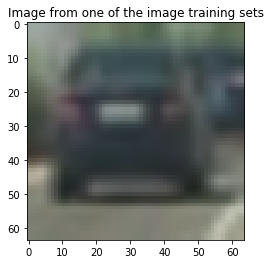

In [5]:
# Read one of the images using OpenCV
#img_BGR = cv2.imread(v_img_set[64])
#img_BGR = cv2.imread('../Vehicles_Sets/vehicles/GTI_Far/image0658.png')
#img_BGR = cv2.imread('./test_images/scrshot01.png')
img_BGR = cv2.imread('../Vehicles_Sets/vehicles/GTI_Far/image0000.png')
img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Image from one of the image training sets')
plt.show()

In [6]:
# Showing the RGB number arrays making up the picture
img[0][:2]

array([[156, 168, 163],
       [156, 168, 163]], dtype=uint8)

In [7]:
#### Converting an image to HLS color space, because Hue is helpful to catch yellow lanes
#### while Lightness and Saturation are helpful to find both lanes
def apply_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hue_img = hls[:,:,0]
    light_img = hls[:,:,1]
    sat_img = hls[:,:,2]
    
    return (hue_img, light_img, sat_img)

In [8]:
res_img = apply_hls(img)

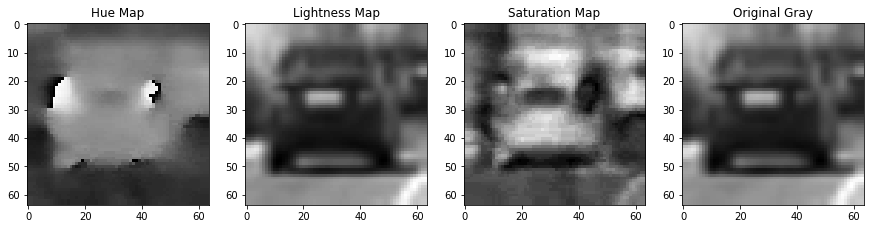

In [9]:
img_gr = cv2.cvtColor(img_BGR, cv2.COLOR_RGB2GRAY)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,10))

ax1.set_title('Hue Map')
ax1.imshow(res_img[0], cmap = 'gray')

ax2.set_title('Lightness Map')
ax2.imshow(res_img[1], cmap = 'gray')

ax3.set_title('Saturation Map')
ax3.imshow(res_img[2], cmap = 'gray')

ax4.set_title('Original Gray')
ax4.imshow(img_gr, cmap = 'gray')

plt.show()

In [10]:
# extract the Histogram of Oriented Gradient from a picture
from skimage.feature import hog

pix_per_cell = 8
cell_per_block = 2
orient = 4

features, hog_image = hog(img_gr, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

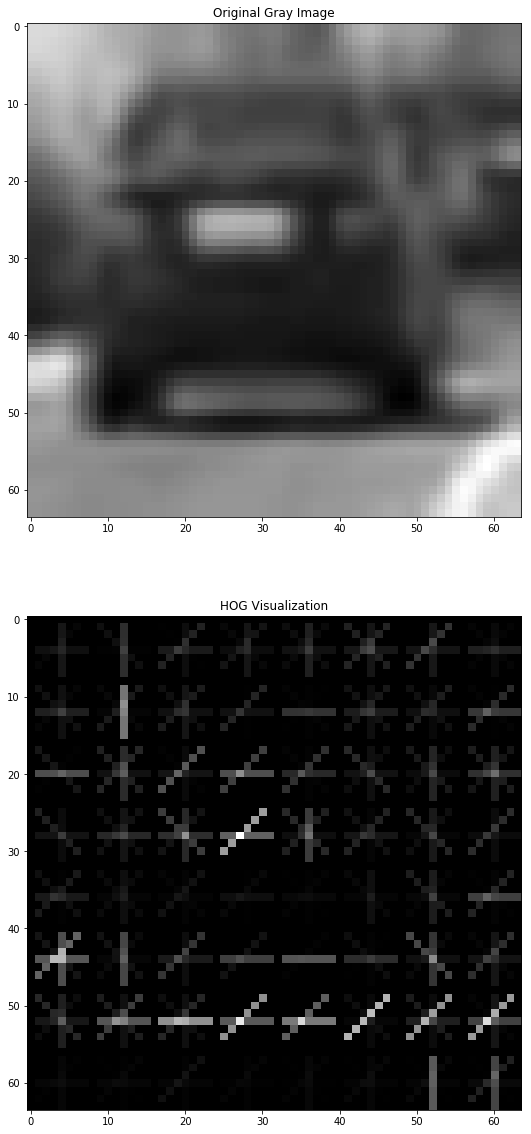

In [11]:
f, (ax1, ax2) = plt.subplots(2,1, figsize=(30,20))

ax1.set_title('Original Gray Image')
ax1.imshow(img_gr, cmap = 'gray')

ax2.set_title('HOG Visualization')
ax2.imshow(hog_image, cmap = 'gray')

plt.show()

In [12]:
print(features.shape)

(7, 7, 2, 2, 4)


In [13]:
new = features.ravel()
print(len(new))

784


In [14]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)
        return features

In [15]:
# Now we need to take all our paths to our images, read them and get their HOG features 
# and save the results in a new list called total_img_set
total_img_set = []
pix_per_cell = 8
cell_per_block = 2
orient = 4

for img_path in total_img_set_path:
    img_BGR = cv2.imread(img_path)
    img_gr = cv2.cvtColor(img_BGR, cv2.COLOR_RGB2GRAY)
    hog_features =  get_hog_features(img_gr, orient, pix_per_cell, cell_per_block)
    # now we have to 'flatten' the array of hog features
    flat_array = hog_features.ravel()
    total_img_set.append(flat_array)

In [16]:
print(len(total_img_set))

17760


In [17]:
print(total_img_set[0].shape)

(784,)


In [18]:
#from sklearn.cross_validation import train_test_split
# But, if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split

In [33]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    total_img_set, y, test_size=0.8, random_state=rand_state)

In [34]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

3552
3552
14208
14208


In [35]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear','rbf'), 'C':[0.1, 1, 10]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [ ]:
X_train[0]

In [26]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(iris.data, iris.target)
#clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [ ]:
print(type(iris.data))

In [ ]:
print(iris.data.shape)

In [ ]:
print(iris.data[0].shape)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
import statistics

%matplotlib inline

img = mpimg.imread('camera_cal/calibration1.jpg')

f, (ax) = plt.subplots(1,1, figsize=(5,5))
ax.set_title('Example of Image Used for Calibration')
ax.imshow(img)
plt.show()

In [ ]:
cal_imgs = glob.glob('camera_cal/calibration*.jpg')
print('# of images used for camera calibration:', len(cal_imgs))

In [ ]:
# Storing the object points and image points for all the images from the image calibration list

objpoints = [] #3D points coordinates representing the true (i.e. undistorted) positions of chessboard corners
imgpoints = [] #2D points coordinates from the chessboard corners in an image

In [ ]:
# Prepare object points. Based on pictures we have a 9x6 chessboard (i.e. number of valid corners)
# Creating an array that will store the (x, y, z) values of each corner
# For example the value of the first corner will be (0, 0, 0)
# Note: since chessboard is flat, the z value of each corner coordinate will always be 0 here

# Creating an initial array with 9x6 = 54 lists each holding 3 values (i.e. x, y, and z values)
objp = np.zeros((9*6,3), np.float32)

# Right now all the lists values in objp are (0, 0, 0) so there are just placeholders. 
# We will generate the right coordinate for each list value in objp
objp[:, :2] = np.mgrid[0:9,0:6].T.reshape(-1, 2) # overwrite x, y coordinates with new correct values for each point

In [ ]:
# Loop through all the images in the list of calibrating images
# Find the chessboard corners on each image
corners_9x6 = []
corners_not_found = []
counter = 0

for img_path in cal_imgs:
    # read the image
    img = mpimg.imread(img_path)
    # convert an image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    counter +=1 
   
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are detected, add object points and image points from the chessboard image analyzed
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        corners_9x6.append(img_path)

        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        # show an image with the corners found
        if counter ==  4 or counter == 9:
            f, (ax) = plt.subplots(1,1, figsize=(5,5))
            ax.set_title('Example of Image with 9x6 Corners Found')
            ax.imshow(img)
            plt.show()
    
    else:
        corners_not_found.append(img_path)


print('\n9x6 corners found for {} images'.format(len(corners_9x6)))
print('9x5 corners not found for {} images'.format(len(corners_not_found)))

In [ ]:
# Reading a grayscale, distorted image, which we're going to use for final calibration
img = mpimg.imread('camera_cal/calibration2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#Calibrating the camera using a grayscale image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#### Function to undistort an image
#### Returns the original image and the undistorted image
def show_undst(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return [img, dst]


In [ ]:
cal_img = mpimg.imread('camera_cal/calibration1.jpg')
test = show_undst(cal_img)

f, (ax) = plt.subplots(1,1, figsize=(5,5))
ax.set_title('Example of Calibrated (i.e. Undistorted) Image')
ax.imshow(test[1])
plt.show()

In [ ]:
# Read one of the road test images
reference = 'test_images/test2.jpg'
img = mpimg.imread(reference)

# Undistorting the test image
test = show_undst(img)
img_width = img.shape[1]
img_height = img.shape[0]


print('road image is of shape ', img.shape)

f, (ax) = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Image before reducing distortion')
ax.imshow(img)
plt.show()

f, (ax) = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Image after reducing distortion')
ax.imshow(test[1])
plt.show()


In [ ]:
# xy coordinates of the points that represent a rectangle on a bird's eye view of the road
# these coordinates will help us in getting rid of perspective so we can analyze and detect lane lines
bt_l_x = 185  # x of bottom-left corner
bt_r_x = 1095  # x of bottom-right corner
top_l_x = bt_l_x+410  # x of top-left corner
top_r_x = bt_r_x-410  # x of top-right corner
bt_y = 720 # 716
top_y = 450 # 450


In [ ]:
#### Function to warp/unwarp perspective in an image
#### Returns a list with: warped image (i.e. bird's eye view), the warped image unwarped (i.e. perspective reapplied)
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Coordinates of 4 points on image. These points form a rectangle when unwarped
    src = np.float32(
        [[top_r_x, top_y],
         [bt_r_x, bt_y],
         [bt_l_x, bt_y],
         [top_l_x, top_y]])

    # Coordinates of these 4 points when unwarped
    dst = np.float32(
        [[bt_r_x-150, 0],
         [bt_r_x-150, bt_y],
         [bt_l_x+150, bt_y],
         [bt_l_x+150, 0]])
       
    # Compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse of perspective transform, by just swapping the dst and src parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image by using linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    reverted = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
       
    return [warped, reverted]

In [ ]:
# Apply the warp function to our undistorted image
transformed_imgs = warp(test[1])

# Make a copies of the warped image (we don't want to modify the original)
warped_img = transformed_imgs[0].copy()
warped_img_c = transformed_imgs[0].copy()
# Make a copy of the perspective image (we don't want to modify the original)
persp_img = test[1].copy()

In [ ]:
#### visual comparison of the original image (with perspective 'rectangle') and warped image (bird's eye view)
def compare_imgs(undistored_img, bird_view_img):

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

    ax1.set_title('Original image')
    # Draw a red polygon showing lane perspective
    pts = np.array([[bt_l_x,bt_y],[top_l_x,top_y],[top_r_x,top_y],[bt_r_x,bt_y]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(undistored_img,[pts],True,(255,0,0),4)
    ax1.imshow(undistored_img)

    ax2.set_title('Warped image')
    # Draw parallel red and blue lines on a bird's eye view of the road
    real_pts = np.array([[bt_l_x+150,bt_y],[bt_l_x+150,0],[bt_r_x-150,0],[bt_r_x-150,bt_y]], np.int32)
    cv2.line(bird_view_img, (bt_l_x+150,bt_y), (bt_l_x+150,0), (255, 0, 0), 10)
    cv2.line(bird_view_img, (bt_r_x-150,bt_y), (bt_r_x-150,0), (0, 0, 255), 10)
    ax2.imshow(bird_view_img)

In [ ]:
# Compare the original road test image with the warped image of the road (i.e. bird's eye view)
compare_imgs(persp_img, warped_img_c)

In [ ]:
# We can revert the warped image back to the original perspective using 
# the warp() function
reverted_imgs = warp(warped_img_c)
revert_back = reverted_imgs[1]
plt.imshow(revert_back)
plt.show()

In [ ]:
#### Find the edges in the picture using the Sobel function in OpenCV
#### the default is 'x' to find mostly vertical edges (since our lane lines are mostly vertical)
def absolute_sobel(img, orient='x', thresh_min=20, thresh_max=100):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply cv2.Sobel()
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    return scaled_sobel

In [ ]:
#### Converting an image to HLS color space, because Hue is helpful to catch yellow lanes
#### while Lightness and Saturation are helpful to find both lanes
def apply_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hue_img = hls[:,:,0]
    light_img = hls[:,:,1]
    sat_img = hls[:,:,2]
    
    return (hue_img, light_img, sat_img)

In [ ]:
#### Converting an image to a binary showing only the pixels whose value was within a threshold
def to_binary(img, thresh_min, thresh_max):
    binary = np.zeros_like(img)
    binary[(img >= thresh_min) & (img <= thresh_max)] = 1
    # Create binary_output
    return binary

In [ ]:
#### Take an image and apply to it all the filters (sobel and HLS)
def apply_filters(img):
    sb = absolute_sobel(img)
    sb_binary = to_binary(sb, 20, 100)
    
    hue, light, sat = apply_hls(img)
    hue_binary = to_binary(hue, 17, 50)
    light_binary =  to_binary(light, 190, 255)
    sat_binary = to_binary(sat, 100, 255)
    
    return(sb, sb_binary, hue, hue_binary, light, light_binary, sat, sat_binary)

In [ ]:
sobel, sobel_binary, H, H_binary, L, L_binary, S, S_binary = apply_filters(warped_img)

In [ ]:
#### Visual comparison of images
def compare_two_imgs(w_img1, w_img2, title_1, title_2):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

    ax1.set_title(title_1)
    ax1.imshow(w_img1, cmap = 'gray')
    
    ax2.set_title(title_2)
    ax2.imshow(w_img2, cmap = 'gray') 

In [ ]:
compare_two_imgs(sobel, sobel_binary, "Sobel Image", "Sobel Binary")
compare_two_imgs(H, H_binary, "Hue Image", "Hue Binary")
compare_two_imgs(L, L_binary, "Lightness Image", "Lightness Binary")
compare_two_imgs(S, S_binary, "Saturation Image", "Saturation Binary")

In [ ]:
#### Combine the binary results from all the filter to get the pixels that are good candidates
#### to draw lane lines
def show_lines(sb_bin, hue_bin, light_bin, sat_bin):
    binary = np.zeros_like(sb_bin)
    binary[(sb_bin == 1) | (hue_bin == 1) | (light_bin == 1) | (sat_bin == 1)] = 1
    # Create binary_output
    return binary

In [ ]:
#### Combine the binary results from all the filters to get the pixels that are good candidates
#### to draw lane lines. 
#### show_lines2() differ from show_lines() in that it will only retain a pixel
#### if the same pixel is white in at least two binary results
def show_lines2(sb_bin, hue_bin, light_bin, sat_bin):
    binary = np.zeros_like(sb_bin)
    binary[(((sb_bin == 1) | (hue_bin == 1)) & ((light_bin == 1) | (sat_bin == 1))) | (((sb_bin == 1) | (light_bin == 1)) & ((hue_bin == 1) | (sat_bin == 1)))] = 1
    # Create binary_output
    return binary

In [ ]:
final = show_lines(sobel_binary, H_binary, L_binary, S_binary)
final2 = show_lines2(sobel_binary, H_binary, L_binary, S_binary)
binary_warped = final2.copy()

In [ ]:
# comparing results from the two methods
compare_two_imgs(final, binary_warped, "Pixels retained using Showlines()", 
                 'Pixels retained using modified function: Showlines2()')


In [ ]:
# Define global variables that we use to store info about our previously found lanes
glob_left_fit_list = []
glob_right_fit_list = []
glob_curvatures = []
glob_mean_curvs = []
glob_curvature = 0.0
glob_dist_ctr = 0.0
glob_counter = 0

In [ ]:
#### Thorough lane search
#### This will use search windows scanning vertically accross the image (for both the left and right lines)
#### If a certain number of nonzeros (i.e. 'white pixels') are found in the window, they are considered
#### as valid in our search for the lane. Additionally, if more than a certain number of valid pixels (minpix)
#### are found in one window, then the next search window up will have its center based on the 
#### mean position of these pixels in the previous search window
def thorough_lane_search(leftx_base, rightx_base, binary_warped, nonzerox, nonzeroy):
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return [left_lane_inds, right_lane_inds]


In [ ]:
#### Quick lane search
#### Here we assume we already have found the left and right lane lines using a thorough search in a previous
#### frame, so we can narrow the search area for good lane pixels candidates in the binary file
def quick_lane_search(binary_warped, nonzerox, nonzeroy):
    global glob_left_fit_list 
    global glob_right_fit_list
    global glob_counter
    
    A_coeff = []
    B_coeff = []
    C_coeff = []
    
    glob_counter += 1
    for i in glob_right_fit_list:
        A_coeff.append(i[0])
        B_coeff.append(i[1])
        C_coeff.append(i[2])
        med_A = statistics.median(A_coeff)
        med_B = statistics.median(B_coeff)
        med_C = statistics.median(C_coeff)
    
    left_fit = glob_left_fit_list[-1]
    
    # Previous test shows it is more difficult to find the right lane
    # so I'm using average values from previous frame analyses to help create a search area 
    # for the current frame's right lane line
    right_fit = np.array([med_A, med_B, med_C])
    
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # return indices for the left and right lane lines
    return [left_lane_inds, right_lane_inds]

In [ ]:
# Find the max, min and median value in a list of numbers
def find_max_min_med(num_list):
    maximum = max(num_list)
    minimum = min(num_list)
    median = statistics.median(num_list)
    std_dev = stdev(num_list)
    return [maximum, minimum, median, std_dev]

In [ ]:
# Find a line that fits each of the lane lines, using a binary image
def draw_lanes(binary_warped):
    global glob_left_fit_list 
    global glob_right_fit_list
    
    left_lane_inds = None 
    right_lane_inds = None
    # List to store polynomial lines coefficients from previous frames
    A_coeff_right = []
    B_coeff_right = []
    C_coeff_right = []
    
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # If there are no saved polynomial coefficients in glob_left_fit_list or glob_right_fit_list  
    # (which means no lanes were found in the previous frame or frames)
    # then we need to use a more extensive method to find lanes
    if (len(glob_left_fit_list) == 0 or len(glob_right_fit_list) == 0):
        left_lane_inds, right_lane_inds = thorough_lane_search(leftx_base, rightx_base, binary_warped, nonzerox, nonzeroy)

    # If we do already have saved polynomial coefficients in glob_left_fit_list and glob_right_fit_list
    # then we can use them to create narrower ranges to search for the left and right lanes
    else:
        left_lane_inds, right_lane_inds = quick_lane_search(binary_warped, nonzerox, nonzeroy)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
  
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Now that we have our left_fit and right_fit for the lanes, find their curvatures in meters
    find_curvature(binary_warped, left_fit, right_fit, lefty, leftx, righty, rightx)
    # find_curvature() will update a global variable that we can then evaluate in process_image()  
    
    # With left_fit and right_fit for the lanes, we can also find the deviation from the center of the lane
    car_offset(binary_warped, left_fit, right_fit)
    # car offset() will update a global variable that we can use in process_image
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Overwrite the global variables that we use to store info about our previously found lanes
    if len(glob_left_fit_list)>=7:
        glob_left_fit_list = glob_left_fit_list[1:]
    glob_left_fit_list.append(left_fit)
    if len(glob_right_fit_list)>=5:    
        glob_right_fit_list = glob_right_fit_list[1:]
    glob_right_fit_list.append(right_fit)
     
    # Create an image to draw on and an image to show the selection window
    out_img = np.zeros_like(warped_img)
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    lane_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((lane_window1, lane_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0, 255, 0))

    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result


In [ ]:
##### Calculating radius of curvature

# The y values on image increase from top of image to bottom
# so the y value at the bottom is equal to the number of lines in the image: image.shape[0]
# We can evaluate the radius of curvature of left and right lanes at any line of the image
# I'll choose the maximum y-value, corresponding to the bottom of the image
def find_curvature(binary_warped, left_fit, right_fit, lefty, leftx, righty, rightx):
    global glob_curvatures 
    global glob_curvature
    global glob_mean_curvs
    
    y_eval = binary_warped.shape[0]
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 48/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/610 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    glob_curvatures.append([left_curverad, right_curverad])
    glob_curvatures = glob_curvatures[-21:]
    curr_mean_curv = np.mean(glob_curvatures)
    
    glob_mean_curvs.append(curr_mean_curv)
    if len(glob_mean_curvs) >= 42:
        glob_mean_curvs = glob_mean_curvs[-21:]
        temp_curv = np.median(glob_mean_curvs)
        glob_curvature = temp_curv
    elif len(glob_mean_curvs) == 21:
        temp_curv = np.median(glob_mean_curvs)
        glob_curvature = temp_curv
    elif glob_curvature == 0.0:
        glob_curvature = np.median(glob_mean_curvs)


In [ ]:
#### calculating offset of car with regards to center of lane
# we want the x position of each line at the bottom of the image: binary_warped.shape[0]
def car_offset(binary_warped, left_fit, right_fit):
    global glob_dist_ctr
    global glob_counter
    xm_per_pix = 3.7/610 # meters per pixel in x dimension 3.7/700
    
    ploty = binary_warped.shape[0]
    bottom_left_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    bottom_right_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    center_of_lane = int((bottom_right_x - bottom_left_x)/2 + bottom_left_x)
    center_of_img = binary_warped.shape[1]/2

    glob_dist_ctr = (center_of_lane - center_of_img) * xm_per_pix


In [ ]:
bev_color_lanes = draw_lanes(binary_warped)
plt.title('Drawing of lane with valid pixels used for each line')
plt.imshow(bev_color_lanes)
plt.show()

In [ ]:
# Revert warped img to original
reverted_imgs = warp(bev_color_lanes)
revert_back = reverted_imgs[1]
plt.imshow(revert_back)
plt.show()

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
#### This function combines all the other functions used to undistort and unwarp image; 
#### find lane lines, curvature and distance from center; and draw these findings back 
#### on the original image
def process_image(img_feed):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    global glob_curvatures
    global glob_curvature
    global glob_dist_ctr
    
    # copying the image just provided
    img = np.copy(img_feed)
    
    # undistort the image
    undst_img = show_undst(img)
    # return [img, dst]
    
    # Tranform the image so that it looks like bird's eye view
    warped_img = warp(undst_img[1])
    # return [warped, reverted]
    
    # apply all the filters (sobel, HLS)
    # return(sb, sb_binary, hue, hue_binary, light, light_binary, sat, sat_binary)
    sobel, sobel_binary, H, H_binary, L, L_binary, S, S_binary = apply_filters(warped_img[0])
    
    # Determine what data points to keep to find the lanes
    final_binary = show_lines2(sobel_binary, H_binary, L_binary, S_binary)
    # return binary
    binary_warped = final_binary.copy()
    
    # Get bird's eye view image with left and right lanes drawn and the space in between colored
    bev_color_lanes = draw_lanes(binary_warped)
    # return an RGB image
    
    # Revert warped img with colored lanes to original
    reverted_imgs = warp(bev_color_lanes)
    revert_back = reverted_imgs[1]
    
    # Text for distance to center
    if glob_dist_ctr > 0.0:
        dist_text = 'Deviation: {:.01f}m left of center'.format(glob_dist_ctr)
    else:
        dist_text = 'Deviation: {:.01f}m right of center'.format(np.absolute(glob_dist_ctr))
    
    blended_image = cv2.addWeighted(img_feed, 1.0, revert_back, 0.5, 0.0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    mid_curvature = glob_curvature
    curv_info_img = cv2.putText(blended_image,"Curvature: {:.00f}m".format(mid_curvature) ,(20,35), font, 1,(255,255,255),2)
    final_image = cv2.putText(blended_image, dist_text,(500,700), font, 1,(255,255,255),2)
    
    return final_image

In [ ]:
origin_copy = test[1].copy()
new_pic = process_image(origin_copy)

f, (ax) = plt.subplots(1,1, figsize=(10,5))
ax.imshow(new_pic)
plt.show()

In [ ]:
# Reset to 0 the global variables that we use to store info about our previously found lanes
glob_left_fit_list = []
glob_right_fit_list = []
glob_curvatures = []
glob_mean_curvs = []
glob_curvature = 0.0
glob_dist_ctr = 0.0

In [ ]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)